# Collect simulation data for calibration points

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import h5py
import pickle

(positive)>> Applying custom matplotlib settings.


## Outline

1. Load simulation 
2. Compute TD Psi4 Co-Precessing Frame 
3. Symmetrize the co-precessing frame data 
4. Output the symmetrized FD amplitude and phase along with diagnostic plots

## Notes & Conclusions

* Please see executable of the same name. This notebook is just for prototyping.
* minor modifications to this workflow were made for version2 data

## Preliminaries

In [2]:
# Define path for file IO
data_dir = '/Users/book/KOALA/puck/ll/data/version1/'

## Generate data

In [3]:
# Define simulations to load
simulation_keywords = ('q1a04t30_dPm2_T_96_552', 'q1a04t60_dPm1_T_96_552', 'q1a04t90_dP0_T_96_552', 'q1a04t120_dP0_T_96_552', 'q1a04t150_dP0_T_96_552',  'q1a08t30dPm25_T_96_408', 'q1a08t60dPm1.5_T_96_408', 'q1a08t90dPm1_T_96_408', 'q1a08t120dP0_T_96_408', 'q1a08t150dP0_T_96_408', 'q2a04t30dPm2_T_96_408', 'q2a04t60dPm1_T_96_408', 'q2a04t90dPm1_T_96_408', 'q2a04t120_T_96_408', 'q2a04t150_T_96_408', 'q2_a10_a28_ph0_th30', 'q2_a10_a28_ph0_th60', 'q2_a10_a28_ph0_th90', 'q2_a10_a28_ph0_th120', 'q2_a10_a28_ph0_th150', 'q4a04t30_T_96_360', 'q4a04t60dPm1.5D_T_96_360', 'q4a04t90_T_96_360', 'q4a04t120dP0D_T_96_360', 'q4a04t150_T_96_360', 'q4a08t30dPm5p5dRm47_T_96_360', 'q4a08t60dPm3dRm250_T_96_384', 'q4a08t90dPm1D_T_96_384', 'q4a08t120dP1_T_96_360', 'q4a08t150_T_96_360',  'q8a04t30dPm3_T_96_360', 'q8a04t60D_dPm1', 'q8a04t90dP0_T_96_360', 'q8a04t120dPp1_T_96_360', 'q8a04t150dP9_T_96_360', 'q8a08t30dPm9.35_r0.5_T_96_360', 'q8a08t60Ditm45dr075_96_360', 'q8a08t90dP0_T_96_384', 'q8a08t120dP2_r03_T_96_360', 'q8a08t150dP2_T_120_480')

### Find simulations using scsearch 

In [4]:
A = scsearch( keyword=simulation_keywords, notkeyword=('80_Points','ASJmodified','.0.1.0','q8precessing/q8a04t60D_dPm1/'), verbose= True, unique=True )

(scsearch)>> Found keyword (=('q1a04t30_dPm2_T_96_552', 'q1a04t60_dPm1_T_96_552', 'q1a04t90_dP0_T_96_552', 'q1a04t120_dP0_T_96_552', 'q1a04t150_dP0_T_96_552', 'q1a08t30dPm25_T_96_408', 'q1a08t60dPm1.5_T_96_408', 'q1a08t90dPm1_T_96_408', 'q1a08t120dP0_T_96_408', 'q1a08t150dP0_T_96_408', 'q2a04t30dPm2_T_96_408', 'q2a04t60dPm1_T_96_408', 'q2a04t90dPm1_T_96_408', 'q2a04t120_T_96_408', 'q2a04t150_T_96_408', 'q2_a10_a28_ph0_th30', 'q2_a10_a28_ph0_th60', 'q2_a10_a28_ph0_th90', 'q2_a10_a28_ph0_th120', 'q2_a10_a28_ph0_th150', 'q4a04t30_T_96_360', 'q4a04t60dPm1.5D_T_96_360', 'q4a04t90_T_96_360', 'q4a04t120dP0D_T_96_360', 'q4a04t150_T_96_360', 'q4a08t30dPm5p5dRm47_T_96_360', 'q4a08t60dPm3dRm250_T_96_384', 'q4a08t90dPm1D_T_96_384', 'q4a08t120dP1_T_96_360', 'q4a08t150_T_96_360', 'q8a04t30dPm3_T_96_360', 'q8a04t60D_dPm1', 'q8a04t90dP0_T_96_360', 'q8a04t120dPp1_T_96_360', 'q8a04t150dP9_T_96_360', 'q8a08t30dPm9.35_r0.5_T_96_360', 'q8a08t60Ditm45dr075_96_360', 'q8a08t90dP0_T_96_384', 'q8a08t120dP2_r03_

In [5]:
alert('We have found %i simulations.'%len(A))

(notebook)>> We have found 40 simulations.


In [8]:
# 
catalog_path = '/Users/book/KOALA/puck/ll/data/pwca_catalog.sce'
alert('Saving scentry objects to "%s"'%magenta(catalog_path))
pickle.dump( A, open( catalog_path, "wb" ) )

(notebook)>> Saving scentry objects to "/Users/book/KOALA/puck/ll/data/pwca_catalog.sce"


### Load NR data and process

In [135]:

# Define loading parameters 
lmax = 2
pad = 1000
clean = True
dt = 0.5

#
for a in [A[13]]:
    
    #
    alert(a.simname)
    y_raw = gwylm(a,lmax=lmax,dt=dt,pad=pad,clean=clean,verbose=True)
    
    #
    break
    
    

(notebook)>> q8a08t150dP2_T_120_480
(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found enforce_m_relative_sign_convention (=True) keyword.
(gwylm)>> Found lmax (=2) keyword.
(gwylm)>> Found load_dynamics (=True) keyword.
(gwylm)>> Found pad (=1000) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x11dd7caf0>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(__init__)>> Using default M_RELATIVE_SIGN_CONVENTION of 1
(gwylm)>> The (extraction_parameter,level) is (5,7), which differs from the config values of (5,5). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (2, -2), (2, -1), (2, 0), (2, 1)]
(load)>> Using the default extraction_parameter of 5
(load)>> Using the default level of 7
(load)>> Loading: psi3col.r5.l7.l2.m2.gz
(straighten_wfarr!)>> The t

In [146]:
# Manage frames 
frame = {}
frame['raw'] = y_raw

# Put in initial J frame
frame['init-j'] = y_raw.__calc_initial_j_frame__()

# Compute TD adn FD coprecessing psi4 frames
frame['cp-y-fd'] = frame['init-j'].__calc_coprecessing_frame__( transform_domain='fd', kind='psi4' )
frame['cp-y-td'] = frame['init-j'].__calc_coprecessing_frame__( transform_domain='td', kind='psi4' )

(__calc_initial_j_frame__)>> Using bbh data for initial J.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
(__calc_coprecessing_frame__)>> We will use psi4 to compute the co-precessing frame.
(__calc_coprecessing_frame__)>> Transforming to the coprecessing frame using FD angles.
(calc_coprecessing_angles)>> The domain values seem evenly split between positive and negative values. Thus, we will interpret the input as corresponding to FREQUENCY DOMAIN data.
(__calc_coprecessing_frame__)>> Storing radiation axis information to this.radiation_axis_info
(__rotate_frame_at_all_times__!)>> Note that metadata vectors for initial data will be rotated according to positive frequency angles.
(__rotate_frame_at_all_times__)>> Attempting to

In [152]:
# Symmetrise data
foo = dict(frame)
for k in frame:
    if 'cp' in k:
        foo['sym-'+k] = frame[k].__symmetrize__()
#
frame = foo

(notebook)>> Saving diagnostic plot to "/Users/book/KOALA/puck/ll/data/version1/q8a08t150dP2_T_120_480.png"


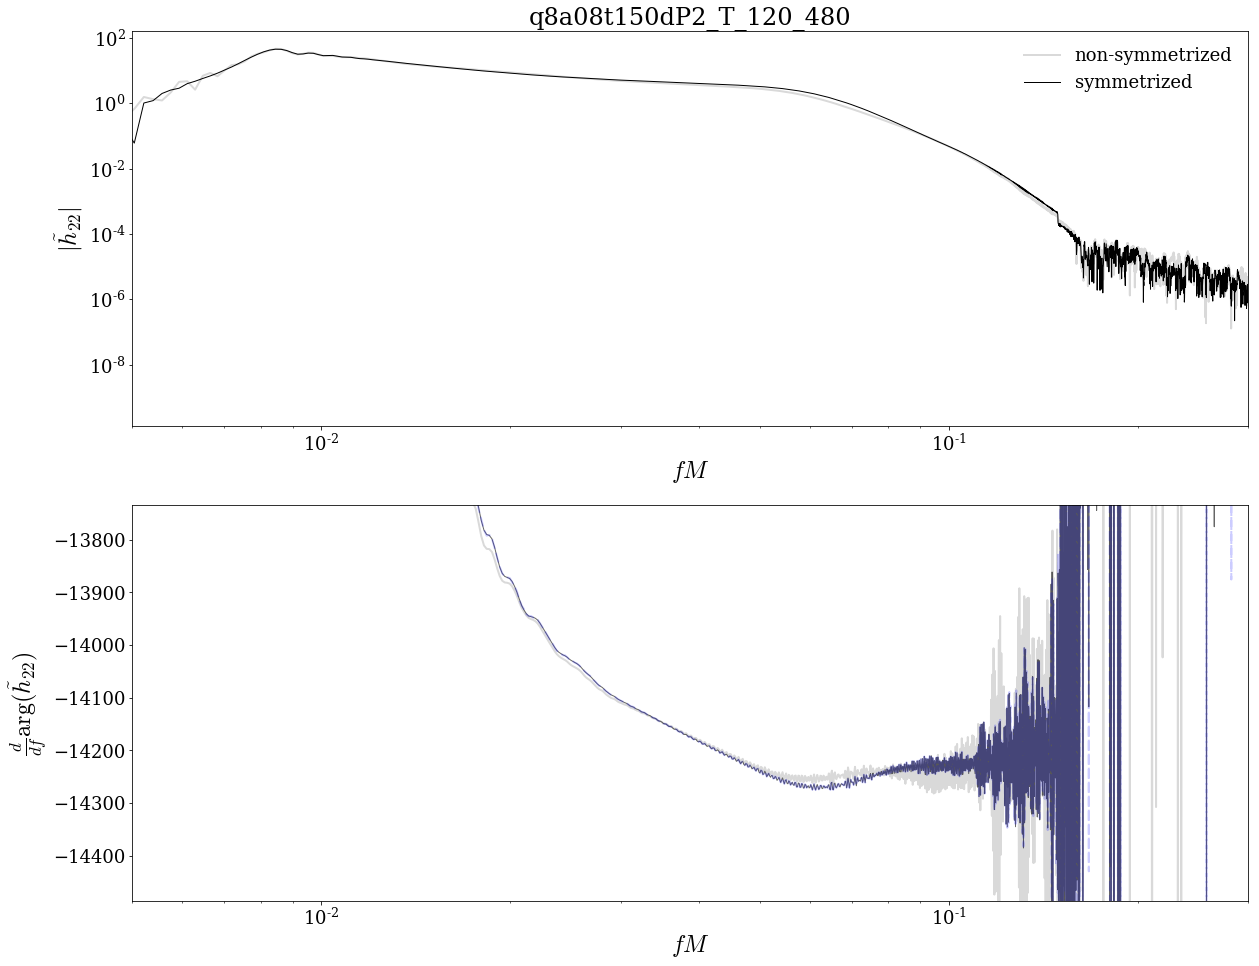

In [186]:
# Produce diagnostic plots 

#
def plot_amp_dphi(frame):

    #
    fig = figure( figsize=4*figaspect(0.8) )

    #
    kind = 'strain'

    #
    f = frame['cp-y-td'].f
    mask = abs(f)<0.1

    #
    k = 'fd'
    ax1 = subplot(2,1,1)
    plot( frame['cp-y-'+k].f, frame['cp-y-'+k][2,2][kind].fd_amp, label='non-symmetrized', color='k', lw=2, alpha=0.15 )
    plot( frame['sym-cp-y-'+k].f, frame['sym-cp-y-'+k][2,2][kind].fd_amp, label='symmetrized',color='k', alpha=1, lw=1 )
    title(y_raw.simname)
    ylabel(r'$|\tilde{h}_{22}|$')

    #
    yscale('log')
    xscale('log')
    legend()
    xlabel('$fM$')

    #
    kind = 'psi4'

    #
    k = 'fd'
    ax2=subplot(2,1,2,sharex=ax1)
    plot( frame['cp-y-'+k].f, frame['cp-y-'+k][2,2][kind].fd_dphi, label='non-symmetrized', color='k', lw=2, alpha=0.15 )
    plot( frame['sym-cp-y-'+k].f, frame['sym-cp-y-'+k][2,2][kind].fd_dphi, label='symmetrized',color='k', alpha=1, lw=1 )

    #
    xscale('log')
    xlim( 0.005, 0.3 )
    ylim( frame['cp-y-'+k][2,2]['strain'].fd_dphi[mask][-1]-250,frame['cp-y-'+k][2,2]['strain'].fd_dphi[mask][-1]+500 )
    xlabel('$fM$')
    ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$');
    
    #
    return fig,[ax1,ax2]
    
#
fig,ax = plot_amp_dphi(frame)
file_path = data_dir+'%s.png'%frame['raw'].simname
alert('Saving diagnostic plot to "%s"'%yellow(file_path))
savefig( file_path )

In [194]:
# save data
import pickle
import dill

#
k = frame['raw'].f>0
f = frame['raw'].f
amp  = frame['sym-cp-y-fd'][2,2]['strain'].fd_amp
dphi = frame['sym-cp-y-fd'][2,2]['psi4'].fd_dphi
data_array = array([ f, amp, dphi ]).T[k]

#
file_path = data_dir+'%s.txt'%frame['raw'].simname
alert('Saving waveform data to "%s"'%yellow(file_path))
# pickle.dump( data_array, open( file_path, "wb" ) )
savetxt( file_path, data_array, header='[ f, fd_amp, fd_dphi ], frequencies are positive, waveform info are symmetrized from NR simulation at %s'%frame['raw'].simdir )

(notebook)>> Saving waveform data to "/Users/book/KOALA/puck/ll/data/version1/q8a08t150dP2_T_120_480.txt"


In [195]:
len(f[k])

5562

In [196]:
len(y_raw.t)

11126